# Capstone project function 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern, WhiteKernel
import matplotlib.pyplot as plt
import sklearn
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from scipy.interpolate import griddata
import ast
from scipy.stats import norm

/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Description of function 3

You’re working on a drug discovery project, testing combinations of three compounds to create a new medicine.

Each experiment is stored in initial_inputs.npy as a 3D array, where each row lists the amounts of the three compounds used. After each experiment, you record the number of adverse reactions, stored in initial_outputs.npy as a 1D array.

Your goal is to minimise side effects; in this competition, it is framed as maximisation by optimising a transformed output (e.g. the negative of side effects). 

Inputs are 3D array (15,3) and output is 1D array (15,1)

### Step 1: Import data and visualise

In [2]:
X = np.load('Initial_inputs.npy')
y = np.load('Initial_outputs.npy')

inputdata = np.load('Initial_inputs.npy')
outputdata = np.load('Initial_outputs.npy')

print(X, y)

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]] [-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837]


In [22]:
# Transform y so that you are converting this to maximise negative side effects
y_transform = -y
print(y_transform)

[0.1121222  0.08796286 0.11141465 0.03483531 0.04800758 0.11062091
 0.39892551 0.11386851 0.13146061 0.09418956 0.04694741 0.10596504
 0.11804826 0.03637783 0.05675837]


### Step 2: Visualise the data

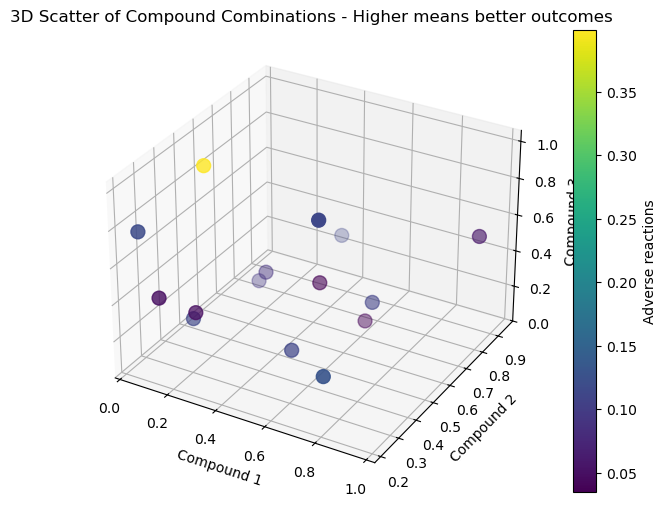

In [46]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X[:,0], X[:,1], X[:,2], c=y_transform, cmap='viridis', s=100)
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Compound 3')
plt.colorbar(sc, label='Adverse reactions')
plt.title('3D Scatter of Compound Combinations - Higher means better outcomes')
plt.show()

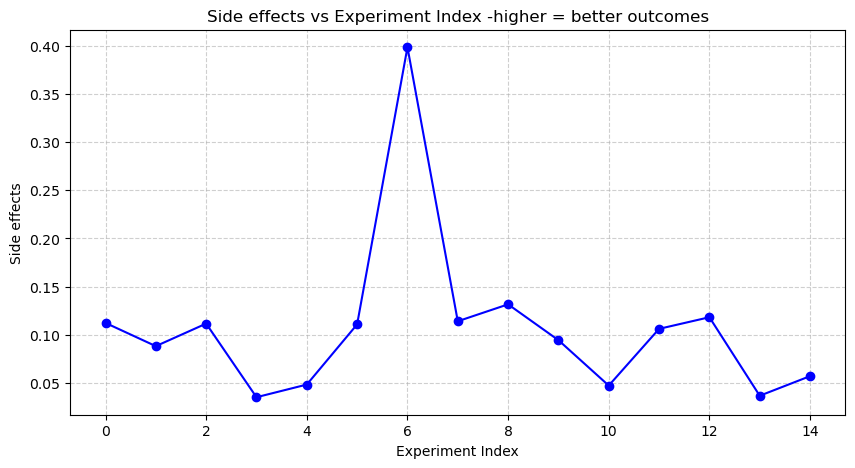

In [48]:
indices = np.arange(len(y_transform))

plt.figure(figsize=(10,5))
plt.plot(indices, y_transform, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Side effects')
plt.title('Side effects vs Experiment Index -higher = better outcomes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### Step 3: Fit surrogate model - A Gaussian processor

In [24]:
kernel = Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X, y_transform)

GaussianProcessRegressor(kernel=Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10, random_state=42)

### Step 4: Apply acquisition function

In [25]:
num_candidates = 10000
X_candidates = np.random.rand(num_candidates, 3)

mu, sigma = gp.predict(X_candidates, return_std=True)

kappa = 3.0  # exploration-exploitation tradeoff
UCB = mu + kappa * sigma

### Step 5: Identify next logical step using UCB

In [26]:
next_idx = np.argmax(UCB)
x_next = X_candidates[next_idx]
print("Next combination to try (UCB):", x_next)


Next combination to try (UCB): [0.0144579  0.97950588 0.94105   ]


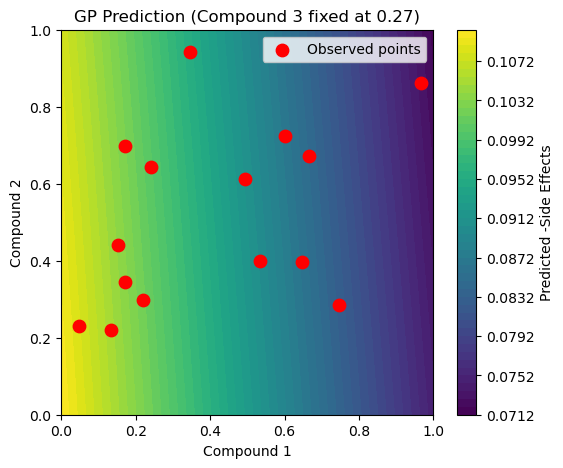

In [27]:
#Visualise 

fixed_c3 = np.median(X[:,2])
x1 = np.linspace(0,1,50)
x2 = np.linspace(0,1,50)
X1, X2 = np.meshgrid(x1, x2)
X_grid = np.column_stack([X1.ravel(), X2.ravel(), np.full(X1.size, fixed_c3)])
mu_slice, sigma_slice = gp.predict(X_grid, return_std=True)

plt.figure(figsize=(6,5))
plt.contourf(X1, X2, mu_slice.reshape(X1.shape), levels=50, cmap='viridis')
plt.colorbar(label='Predicted -Side Effects')
plt.scatter(X[:,0], X[:,1], c='red', s=80, label='Observed points')
plt.xlabel('Compound 1')
plt.ylabel('Compound 2')
plt.title(f'GP Prediction (Compound 3 fixed at {fixed_c3:.2f})')
plt.legend()
plt.show()

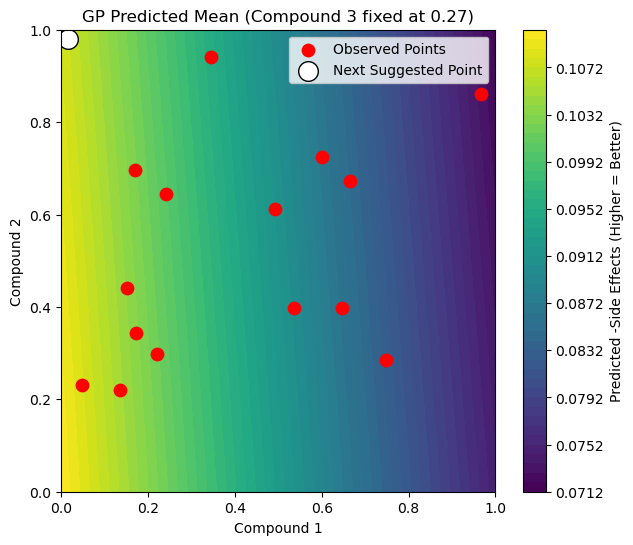

In [28]:
# Fix compound 3 at its median
fixed_c3 = np.median(X[:,2])
x1 = np.linspace(0, 1, 80)
x2 = np.linspace(0, 1, 80)
X1, X2 = np.meshgrid(x1, x2)

# Build grid for GP prediction
X_grid = np.column_stack([X1.ravel(), X2.ravel(), np.full(X1.size, fixed_c3)])
mu_grid, sigma_grid = gp.predict(X_grid, return_std=True)

# ----------------------------
# Plot GP mean with next point
# ----------------------------
plt.figure(figsize=(7,6))
plt.contourf(X1, X2, mu_grid.reshape(X1.shape), levels=60, cmap='viridis')
plt.colorbar(label='Predicted -Side Effects (Higher = Better)')

# Existing data points
plt.scatter(X[:,0], X[:,1], c='red', s=80, label='Observed Points')

# Mark next predicted best point
plt.scatter(x_next[0], x_next[1], c='white', edgecolors='black', s=200, marker='o', label='Next Suggested Point')

plt.xlabel('Compound 1')
plt.ylabel('Compound 2')
plt.title(f'GP Predicted Mean (Compound 3 fixed at {fixed_c3:.2f})')
plt.legend()
plt.show()

## ******** Week 2 - update of data and optimisation ********

### Step 1: Load in new data received and plot

In [5]:
inputdata = np.load('Initial_inputs.npy')
outputdata = np.load('Initial_outputs.npy')

#Read in text file of inputs
with open('../Inputs_outputs/Week1/inputs.txt', 'r') as f:
    inputs_week2 = f.read()

with open('../Inputs_Outputs/Week1/outputs.txt', 'r') as f:
    outputs_week2 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week2 = eval(inputs_week2, {"__builtins__": {}}, safe_globals)
outputs_week2 = eval(outputs_week2, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week2 = np.array(inputs_week2, dtype=object)
outputs_week2 = np.array(outputs_week2, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F3_inputs_week2 = inputs_week2[2]
F3_outputs_week2 = outputs_week2[2]


# Step 5: merge with previous data
F3_inputs_week2 = F3_inputs_week2.reshape(1, -1)
inputdata_week2 = np.concatenate((inputdata,F3_inputs_week2), axis=0)

outputdata_week2 = np.concatenate((outputdata,np.array([F3_outputs_week2])))

print(inputdata_week2)
print(outputdata_week2)

# Save updated files
np.save('inputs_week2.npy',inputdata_week2)
np.save('outputs_week2.npy',outputdata_week2)

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]
 [0.05117    0.957489   0.994646  ]]
[-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837 -0.46766566]


[0.1121222  0.08796286 0.11141465 0.03483531 0.04800758 0.11062091
 0.39892551 0.11386851 0.13146061 0.09418956 0.04694741 0.10596504
 0.11804826 0.03637783 0.05675837 0.46766566]


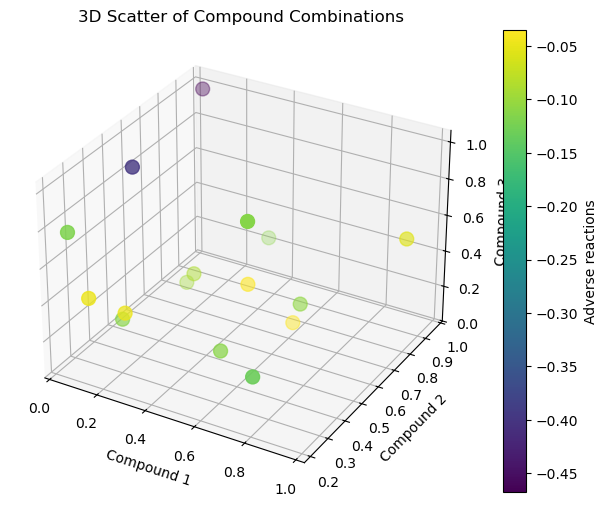

In [37]:
X_wk2 = inputdata_week2
y_wk2 = outputdata_week2

y_transform_wk2 = -y_wk2
print(y_transform_wk2)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_wk2[:,0], X_wk2[:,1], X_wk2[:,2], c=y_wk2, cmap='viridis', s=100)
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Compound 3')
plt.colorbar(sc, label='Adverse reactions')
plt.title('3D Scatter of Compound Combinations')
plt.show()

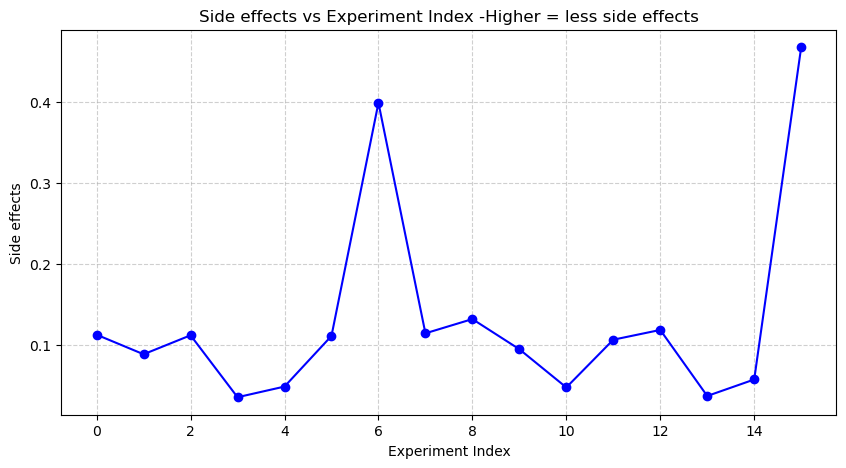

Best parameters: [0.05117  0.957489 0.994646]
Best yield: -0.46766566494703565


In [49]:
### what are the best outcomes
indices = np.arange(len(y_transform_wk2))

plt.figure(figsize=(10,5))
plt.plot(indices, y_transform_wk2, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Side effects')
plt.title('Side effects vs Experiment Index -Higher = less side effects')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(y_transform_wk2)
best_x = inputdata_week2[best_idx]
best_y = outputdata_week2[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

### Step 2: Refit the surrogate model with the updated points

In [38]:
kernel = Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_wk2, y_transform_wk2)

GaussianProcessRegressor(kernel=Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10, random_state=42)

In [39]:
num_candidates = 10000
X_candidates = np.random.rand(num_candidates, 3)

mu, sigma = gp.predict(X_candidates, return_std=True)

kappa = 3.0  # exploration-exploitation tradeoff
UCB = mu + kappa * sigma

### Step 3: Fit the acquisition parameter

In [40]:
next_idx = np.argmax(UCB)
x_next = X_candidates[next_idx]
print("Next combination to try (UCB):", x_next)

Next combination to try (UCB): [0.0102655  0.94182389 0.95375641]


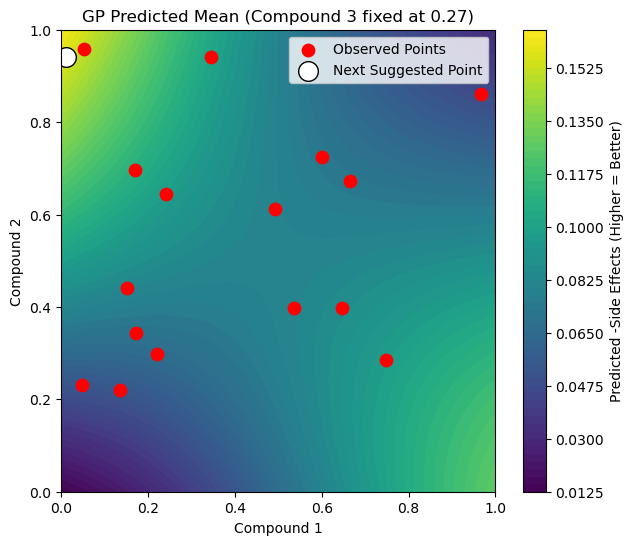

In [41]:
#Visualise 

# Fix compound 3 at its median
fixed_c3 = np.median(X[:,2])
x1 = np.linspace(0, 1, 80)
x2 = np.linspace(0, 1, 80)
X1, X2 = np.meshgrid(x1, x2)

# Build grid for GP prediction
X_grid = np.column_stack([X1.ravel(), X2.ravel(), np.full(X1.size, fixed_c3)])
mu_grid, sigma_grid = gp.predict(X_grid, return_std=True)

# ----------------------------
# Plot GP mean with next point
# ----------------------------
plt.figure(figsize=(7,6))
plt.contourf(X1, X2, mu_grid.reshape(X1.shape), levels=60, cmap='viridis')
plt.colorbar(label='Predicted -Side Effects (Higher = Better)')

# Existing data points
plt.scatter(X_wk2[:,0], X_wk2[:,1], c='red', s=80, label='Observed Points')

# Mark next predicted best point
plt.scatter(x_next[0], x_next[1], c='white', edgecolors='black', s=200, marker='o', label='Next Suggested Point')

plt.xlabel('Compound 1')
plt.ylabel('Compound 2')
plt.title(f'GP Predicted Mean (Compound 3 fixed at {fixed_c3:.2f})')
plt.legend()
plt.show()

# ***** Week 3 - Update of data for further optimisation ******

### Step 1: Update inputs and outputs for optimisation

In [6]:
#Load in original input and output data 
inputdata = np.load('inputs_week2.npy')
outputdata = np.load('outputs_week2.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week2/inputs.txt', 'r') as f:
    inputs_week3 = f.read()

with open('../Inputs_Outputs/Week2/outputs.txt', 'r') as f:
    outputs_week3 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week3 = eval(inputs_week3, {"__builtins__": {}}, safe_globals)
outputs_week3 = eval(outputs_week3, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week3 = np.array(inputs_week3, dtype=object)
outputs_week3 = np.array(outputs_week3, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week3 = inputs_week3[2]
F1_outputs_week3 = outputs_week3[2]


# Step 5: merge with previous data
F1_inputs_week3 = F1_inputs_week3.reshape(1, -1)
inputdata_week3 = np.concatenate((inputdata,F1_inputs_week3), axis=0)

outputdata_week3 = np.concatenate((outputdata,np.array([F1_outputs_week3])))

print(inputdata_week3)
print(outputdata_week3)

# Save the results of these
np.save('inputs_week3.npy',inputdata_week3)
np.save('outputs_week3.npy', outputdata_week3)

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]
 [0.05117    0.957489   0.994646  ]
 [0.010266   0.941824   0.953756  ]]
[-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837 -0.46766566 -0.2642263 ]


### Step 2: Visualise updated results

[0.1121222  0.08796286 0.11141465 0.03483531 0.04800758 0.11062091
 0.39892551 0.11386851 0.13146061 0.09418956 0.04694741 0.10596504
 0.11804826 0.03637783 0.05675837 0.46766566 0.2642263 ]


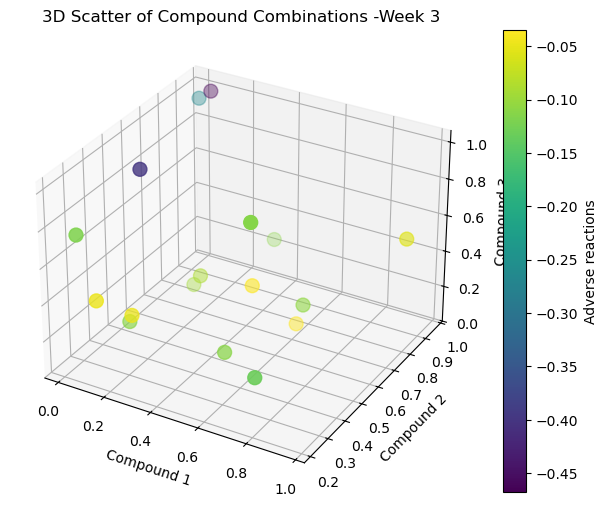

In [7]:
X_wk3 = inputdata_week3
y_wk3 = outputdata_week3

y_transform_wk3 = -y_wk3
print(y_transform_wk3)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_wk3[:,0], X_wk3[:,1], X_wk3[:,2], c=y_wk3, cmap='viridis', s=100)
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Compound 3')
plt.colorbar(sc, label='Adverse reactions')
plt.title('3D Scatter of Compound Combinations -Week 3')
plt.show()

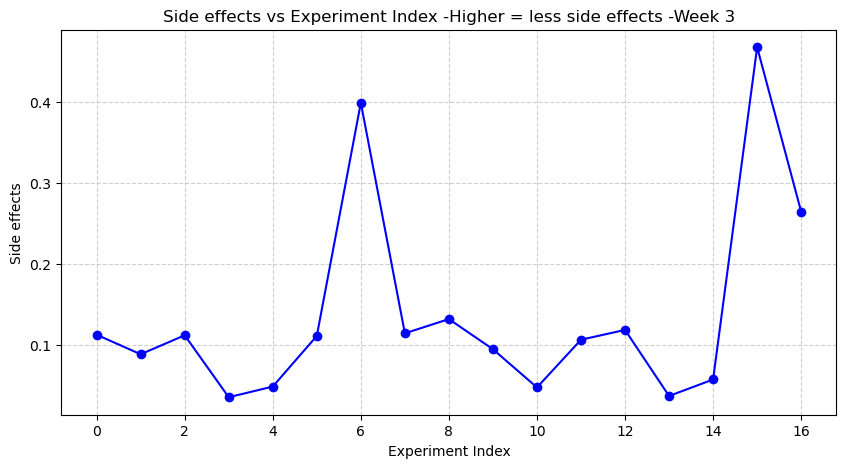

Best parameters: [0.05117  0.957489 0.994646]
Best yield: -0.46766566494703565


In [8]:
### what are the best outcomes
indices = np.arange(len(y_transform_wk3))

plt.figure(figsize=(10,5))
plt.plot(indices, y_transform_wk3, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Side effects')
plt.title('Side effects vs Experiment Index -Higher = less side effects -Week 3')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(y_transform_wk3)
best_x = inputdata_week3[best_idx]
best_y = outputdata_week3[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

### Step 3: Refit the surrogate model -GP with new data

In [9]:
kernel = Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-6)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_wk3, y_transform_wk3)

GaussianProcessRegressor(kernel=Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=1e-06),
                         n_restarts_optimizer=10, random_state=42)

### Step 4: Fit the acquisition function - do we continue to explore or exploit?

In [13]:
num_candidates = 10000
X_candidates = np.random.rand(num_candidates, 3)

mu, sigma = gp.predict(X_candidates, return_std=True)

kappa = 2.0  # exploration-exploitation tradeoff
UCB = mu + kappa * sigma

In [21]:
next_idx = np.argmax(UCB)
x_next = X_candidates[next_idx]
print("Next combination to try (UCB):", np.round(x_next,3))

Next combination to try (UCB): [0.001 0.995 0.98 ]


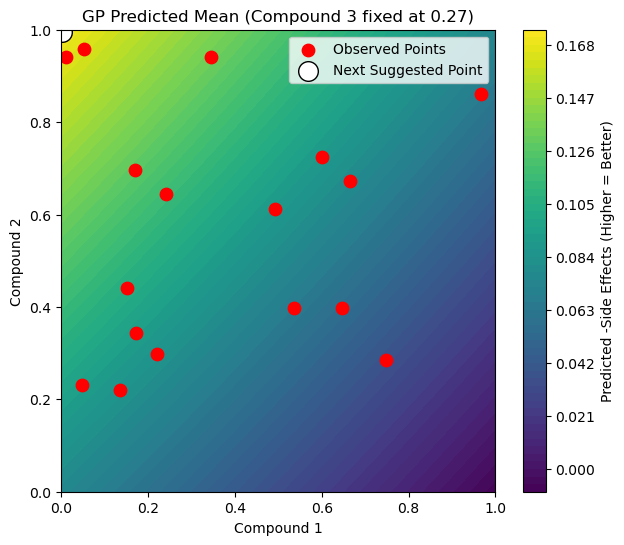

In [15]:
#Visualise 

# Fix compound 3 at its median
fixed_c3 = np.median(X[:,2])
x1 = np.linspace(0, 1, 80)
x2 = np.linspace(0, 1, 80)
X1, X2 = np.meshgrid(x1, x2)

# Build grid for GP prediction
X_grid = np.column_stack([X1.ravel(), X2.ravel(), np.full(X1.size, fixed_c3)])
mu_grid, sigma_grid = gp.predict(X_grid, return_std=True)

# ----------------------------
# Plot GP mean with next point
# ----------------------------
plt.figure(figsize=(7,6))
plt.contourf(X1, X2, mu_grid.reshape(X1.shape), levels=60, cmap='viridis')
plt.colorbar(label='Predicted -Side Effects (Higher = Better)')

# Existing data points
plt.scatter(X_wk3[:,0], X_wk3[:,1], c='red', s=80, label='Observed Points')

# Mark next predicted best point
plt.scatter(x_next[0], x_next[1], c='white', edgecolors='black', s=200, marker='o', label='Next Suggested Point')

plt.xlabel('Compound 1')
plt.ylabel('Compound 2')
plt.title(f'GP Predicted Mean (Compound 3 fixed at {fixed_c3:.2f})')
plt.legend()
plt.show()

# ******* Week 4 - Updated GP with new data *******

## Step 1: Load in new data

In [8]:
#Load in original input and output data 
inputdata = np.load('inputs_week3.npy')
outputdata = np.load('outputs_week3.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week3/inputs.txt', 'r') as f:
    inputs_week4 = f.read()

with open('../Inputs_Outputs/Week3/outputs.txt', 'r') as f:
    outputs_week4 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week4 = eval(inputs_week4, {"__builtins__": {}}, safe_globals)
outputs_week4 = eval(outputs_week4, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week4 = np.array(inputs_week4, dtype=object)
outputs_week4 = np.array(outputs_week4, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week4 = inputs_week4[2]
F1_outputs_week4 = outputs_week4[2]


# Step 5: merge with previous data
F1_inputs_week4 = F1_inputs_week4.reshape(1, -1)
inputdata_week4 = np.concatenate((inputdata,F1_inputs_week4), axis=0)

outputdata_week4 = np.concatenate((outputdata,np.array([F1_outputs_week4])))

print(inputdata_week4)
print(outputdata_week4)

# Save the results of these
np.save('inputs_week4.npy',inputdata_week4)
np.save('outputs_week4.npy', outputdata_week4)

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]
 [0.05117    0.957489   0.994646  ]
 [0.010266   0.941824   0.953756  ]
 [0.001      0.995      0.98      ]]
[-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837 -0.46766566 -0.2642263  -0.38094377]


## Step 2 - Visualise the results

[0.1121222  0.08796286 0.11141465 0.03483531 0.04800758 0.11062091
 0.39892551 0.11386851 0.13146061 0.09418956 0.04694741 0.10596504
 0.11804826 0.03637783 0.05675837 0.46766566 0.2642263  0.38094377]


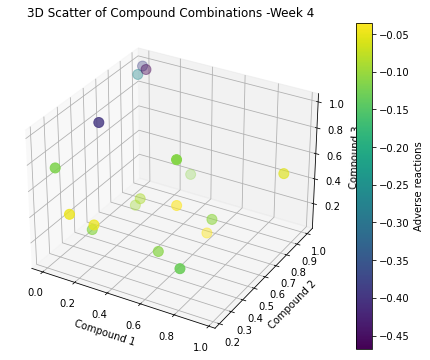

In [9]:
X_wk4 = inputdata_week4
y_wk4 = outputdata_week4

y_transform_wk4 = -y_wk4
print(y_transform_wk4)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_wk4[:,0], X_wk4[:,1], X_wk4[:,2], c=y_wk4, cmap='viridis', s=100)
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Compound 3')
plt.colorbar(sc, label='Adverse reactions')
plt.title('3D Scatter of Compound Combinations -Week 4')
plt.show()

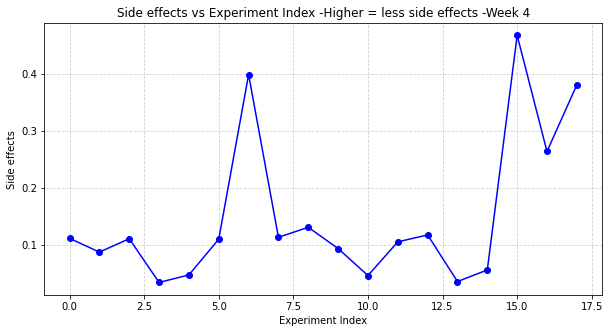

Best parameters: [0.05117  0.957489 0.994646]
Best yield: -0.46766566494703565


In [10]:
### what are the best outcomes
indices = np.arange(len(y_transform_wk4))

plt.figure(figsize=(10,5))
plt.plot(indices, y_transform_wk4, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Side effects')
plt.title('Side effects vs Experiment Index -Higher = less side effects -Week 4')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(y_transform_wk4)
best_x = inputdata_week4[best_idx]
best_y = outputdata_week4[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3 : Refit GP with new data

In [12]:
kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk4, y_transform_wk4)

#Define candidate space
# Assume compounds are dosed between 0 and 1 (or adjust ranges)
x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)

# Create 3D grid of candidates
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidates = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])

### Step 4 - Fit acquisition function

In [16]:
# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)

# Current best
y_max = y_transform_wk4.max()

# Avoid division by zero
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12

# Expected Improvement
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Next experiment: candidate that maximizes EI
x_next = X_candidates[np.argmax(EI)]
print("Next compound combination to try:", np.round(x_next,6))

Next compound combination to try: [0.061224 0.979592 1.      ]


# **** Week 5 data *******

## Step 1: Load in new data

In [3]:
#Load in original input and output data 
inputdata = np.load('inputs_week4.npy')
outputdata = np.load('outputs_week4.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week4/inputs.txt', 'r') as f:
    inputs_week5 = f.read()

with open('../Inputs_Outputs/Week4/outputs.txt', 'r') as f:
    outputs_week5 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week5 = eval(inputs_week5, {"__builtins__": {}}, safe_globals)
outputs_week5 = eval(outputs_week5, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week5 = np.array(inputs_week5, dtype=object)
outputs_week5 = np.array(outputs_week5, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week5 = inputs_week5[2]
F1_outputs_week5 = outputs_week5[2]


# Step 5: merge with previous data
F1_inputs_week5 = F1_inputs_week5.reshape(1, -1)
inputdata_week5 = np.concatenate((inputdata,F1_inputs_week5), axis=0)

outputdata_week5 = np.concatenate((outputdata,np.array([F1_outputs_week5])))

print(inputdata_week5)
print(outputdata_week5)

# Save the results of these
np.save('inputs_week5.npy',inputdata_week5)
np.save('outputs_week5.npy', outputdata_week5)

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]
 [0.05117    0.957489   0.994646  ]
 [0.010266   0.941824   0.953756  ]
 [0.001      0.995      0.98      ]
 [0.061224   0.979592   1.        ]]
[-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837 -0.46766566 -0.2642263  -0.38094377
 -0.46525949]


## Step 2: Plot output data

[0.1121222  0.08796286 0.11141465 0.03483531 0.04800758 0.11062091
 0.39892551 0.11386851 0.13146061 0.09418956 0.04694741 0.10596504
 0.11804826 0.03637783 0.05675837 0.46766566 0.2642263  0.38094377
 0.46525949]


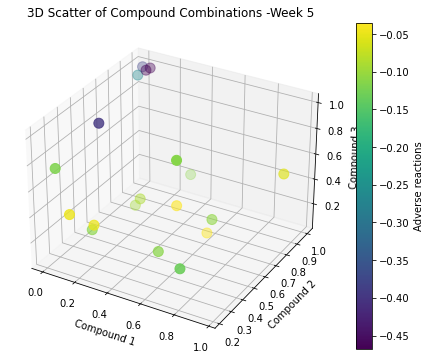

In [4]:
X_wk5 = inputdata_week5
y_wk5 = outputdata_week5

y_transform_wk5 = -y_wk5
print(y_transform_wk5)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_wk5[:,0], X_wk5[:,1], X_wk5[:,2], c=y_wk5, cmap='viridis', s=100)
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Compound 3')
plt.colorbar(sc, label='Adverse reactions')
plt.title('3D Scatter of Compound Combinations -Week 5')
plt.show()

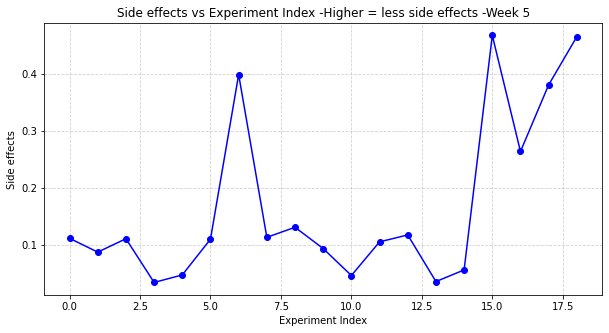

Best parameters: [0.05117  0.957489 0.994646]
Best yield: -0.46766566494703565


In [5]:
### what are the best outcomes
indices = np.arange(len(y_transform_wk5))

plt.figure(figsize=(10,5))
plt.plot(indices, y_transform_wk5, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Side effects')
plt.title('Side effects vs Experiment Index -Higher = less side effects -Week 5')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(y_transform_wk5)
best_x = inputdata_week5[best_idx]
best_y = outputdata_week5[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3: Refit GP surrogate model

In [6]:
kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk5, y_transform_wk5)

#Define candidate space
# Assume compounds are dosed between 0 and 1 (or adjust ranges)
x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)

# Create 3D grid of candidates
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidates = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])

## Step 4: Acquisition function

In [8]:
# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)

# Current best
y_max = y_transform_wk5.max()

# Avoid division by zero
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12

# Expected Improvement
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Next experiment: candidate that maximizes EI
x_next = X_candidates[np.argmax(EI)]
print("Next compound combination to try:", np.round(x_next,6))

Next compound combination to try: [0.102041 0.938776 1.      ]


# **** Week 6 update ****

## Step 1: Load in updated data

In [3]:
#Load in original input and output data 
inputdata = np.load('inputs_week5.npy')
outputdata = np.load('outputs_week5.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week5/inputs.txt', 'r') as f:
    inputs_week6 = f.read()

with open('../Inputs_Outputs/Week5/outputs.txt', 'r') as f:
    outputs_week6 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week6 = eval(inputs_week6, {"__builtins__": {}}, safe_globals)
outputs_week6 = eval(outputs_week6, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week6 = np.array(inputs_week6, dtype=object)
outputs_week6 = np.array(outputs_week6, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week6 = inputs_week6[2]
F1_outputs_week6 = outputs_week6[2]


# Step 5: merge with previous data
F1_inputs_week6 = F1_inputs_week6.reshape(1, -1)
inputdata_week6 = np.concatenate((inputdata,F1_inputs_week6), axis=0)

outputdata_week6 = np.concatenate((outputdata,np.array([F1_outputs_week6])))

print(inputdata_week6)
print(outputdata_week6)

# Save the results of these
np.save('inputs_week6.npy',inputdata_week6)
np.save('outputs_week6.npy', outputdata_week6)

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]
 [0.05117    0.957489   0.994646  ]
 [0.010266   0.941824   0.953756  ]
 [0.001      0.995      0.98      ]
 [0.061224   0.979592   1.        ]
 [0.102041   0.938776   1.        ]]
[-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837 -0.46766566 -0.2642263  -0.38094377
 -0.46525949 -0.46485275]


## Step 2: Plot output

[0.1121222  0.08796286 0.11141465 0.03483531 0.04800758 0.11062091
 0.39892551 0.11386851 0.13146061 0.09418956 0.04694741 0.10596504
 0.11804826 0.03637783 0.05675837 0.46766566 0.2642263  0.38094377
 0.46525949 0.46485275]


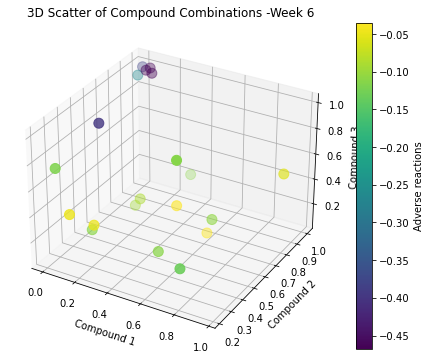

In [5]:
X_wk6 = inputdata_week6
y_wk6 = outputdata_week6

y_transform_wk6 = -y_wk6
print(y_transform_wk6)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_wk6[:,0], X_wk6[:,1], X_wk6[:,2], c=y_wk6, cmap='viridis', s=100)
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Compound 3')
plt.colorbar(sc, label='Adverse reactions')
plt.title('3D Scatter of Compound Combinations -Week 6')
plt.show()

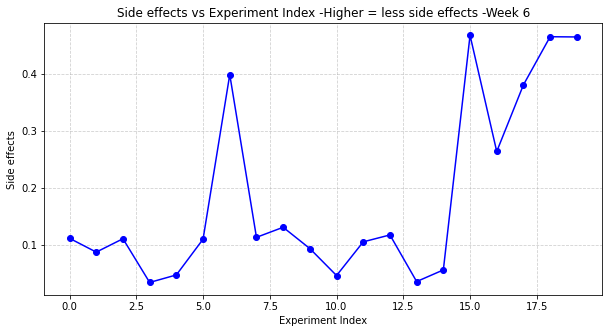

Best parameters: [0.05117  0.957489 0.994646]
Best yield: -0.46766566494703565


In [6]:
### what are the best outcomes
indices = np.arange(len(y_transform_wk6))

plt.figure(figsize=(10,5))
plt.plot(indices, y_transform_wk6, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Side effects')
plt.title('Side effects vs Experiment Index -Higher = less side effects -Week 6')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(y_transform_wk6)
best_x = inputdata_week6[best_idx]
best_y = outputdata_week6[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3: Improve GP surrogate - allow GP to learn kernel length scale 

In [8]:
##Allows different sensitivities per compound
#ν=1.5 captures sharper biological effects
#BO will stop over-smoothing toxicity spikes


kernel = Matern(length_scale=[0.2, 0.2, 0.2],
                length_scale_bounds=(1e-2, 1.0),
                nu=1.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk6, y_transform_wk6)

#Define candidate space
# Assume compounds are dosed between 0 and 1 (or adjust ranges)
x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)

# Create 3D grid of candidates
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidates = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])

/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## Step 4: Acquisition function

In [13]:
# GP predictions
mu, sigma = gp.predict(X_candidates, return_std=True)

# Current best
y_max = y_transform_wk6.max()

# Avoid division by zero
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12

# Expected Improvement
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Next experiment: candidate that maximizes EI
x_next = X_candidates[np.argmax(EI)]
print("Next compound combination to try:", np.round(x_next,6))

Next compound combination to try: [0.       0.795918 1.      ]


# ****** Week 7 ********

## Step 1: Load in updated data

In [2]:
#Load in original input and output data 
inputdata = np.load('inputs_week6.npy')
outputdata = np.load('outputs_week6.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week6/inputs.txt', 'r') as f:
    inputs_week7 = f.read()

with open('../Inputs_Outputs/Week6/outputs.txt', 'r') as f:
    outputs_week7 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week7 = eval(inputs_week7, {"__builtins__": {}}, safe_globals)
outputs_week7 = eval(outputs_week7, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week7 = np.array(inputs_week7, dtype=object)
outputs_week7 = np.array(outputs_week7, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F1_inputs_week7 = inputs_week7[2]
F1_outputs_week7 = outputs_week7[2]


# Step 5: merge with previous data
F1_inputs_week7 = F1_inputs_week7.reshape(1, -1)
inputdata_week7 = np.concatenate((inputdata,F1_inputs_week7), axis=0)

outputdata_week7 = np.concatenate((outputdata,np.array([F1_outputs_week7])))

print(inputdata_week7)
print(outputdata_week7)

# Save the results of these
np.save('inputs_week7.npy',inputdata_week7)
np.save('outputs_week7.npy', outputdata_week7)

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]
 [0.05117    0.957489   0.994646  ]
 [0.010266   0.941824   0.953756  ]
 [0.001      0.995      0.98      ]
 [0.061224   0.979592   1.        ]
 [0.102041   0.938776   1.        ]
 [0.         0.795918   1.        ]]
[-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837 -0.46766566 -0.2642263  -0.38094377
 -0.46525949 -0.46485275

## Step 2: Visualise the data

[0.1121222  0.08796286 0.11141465 0.03483531 0.04800758 0.11062091
 0.39892551 0.11386851 0.13146061 0.09418956 0.04694741 0.10596504
 0.11804826 0.03637783 0.05675837 0.46766566 0.2642263  0.38094377
 0.46525949 0.46485275 0.46150889]


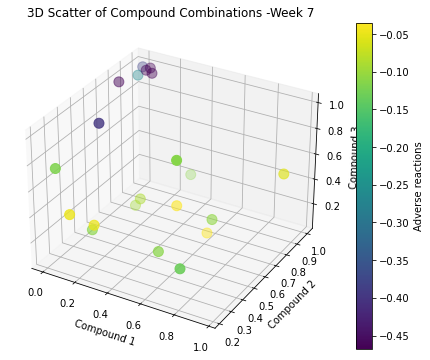

In [3]:
X_wk7 = inputdata_week7
y_wk7 = outputdata_week7

y_transform_wk7 = -y_wk7
print(y_transform_wk7)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_wk7[:,0], X_wk7[:,1], X_wk7[:,2], c=y_wk7, cmap='viridis', s=100)
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Compound 3')
plt.colorbar(sc, label='Adverse reactions')
plt.title('3D Scatter of Compound Combinations -Week 7')
plt.show()

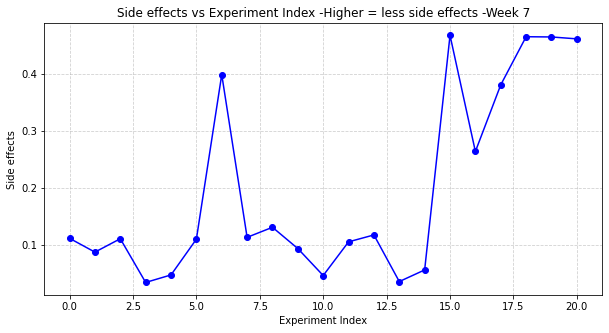

Best parameters: [0.05117  0.957489 0.994646]
Best yield: -0.46766566494703565


In [5]:
### what are the best outcomes
indices = np.arange(len(y_transform_wk7))

plt.figure(figsize=(10,5))
plt.plot(indices, y_transform_wk7, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Side effects')
plt.title('Side effects vs Experiment Index -Higher = less side effects -Week 7')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(y_transform_wk7)
best_x = inputdata_week7[best_idx]
best_y = outputdata_week7[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Ways to try and improve this week 

### Point 1: Update coordinate space, currently ~125k points to choose from. 
### Fix 1: Try a coarse grid with random sampling to see what you get. This can provide less memory intensive search of space that down the line can be coupled with local EI promising regions for further exploitation. 


### Point 2: Length scales may still be too small relative to the function as the current matern kernel is good for sharp effects but may not fully capture where some compounds hve very different sensitivity still. 
### Fix 2: Update the ARD kernel allowing GP to optimize the length scales automatically. Also consider adding white noise kernel if measurements are noisy. This allows the GP to learn the noise level automatically and can help avoid overconfidence.

## Step 3: Update coordinate space to allow for more random sampling + update GP kernel.

In [6]:
# GP kernel with ARD and sharper response

kernel = Matern(
    length_scale=[0.2, 0.2, 0.2],   # separate length scale per compound (ARD)
    length_scale_bounds=(1e-2, 1.0),
    nu=1.5                           # rougher kernel for sharp effects
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-2,             # small observation noise
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=42
)

gp.fit(X_wk7, y_transform_wk7)


# Candidate space (3D grid)


x1 = np.linspace(0, 1, 50)
x2 = np.linspace(0, 1, 50)
x3 = np.linspace(0, 1, 50)

X1, X2, X3 = np.meshgrid(x1, x2, x3)
X_candidates = np.column_stack([X1.ravel(), X2.ravel(), X3.ravel()])


# GP predictions

mu, sigma = gp.predict(X_candidates, return_std=True)

# Avoid divide by zero
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12


/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## Step 4: Update acquisition function

In [7]:
# Expected Improvement 

y_max = y_transform_wk7.max()
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0


# Select next candidate

x_next = X_candidates[np.argmax(EI)]
print("Next compound combination to try:", np.round(x_next,6))

Next compound combination to try: [0.22449  0.836735 1.      ]
